## Setup
Run the following cell (it should take a few minutes to install packages and load datasets)

Make sure you are running the colab with a T4-GPU instead of the normal CPU setup.

In [ ]:
# Install required libraries
!pip install -q spacy sentence-transformers datasets

# Download spaCy model with word vectors (use 'md' for real vectors)
!python -m spacy download en_core_web_md

# Download required NLTK data
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("words")

# Download example text file
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dSl2QJhVUr93yPUnakzXqmrK5ZKBTciz' -O cleaned-tcn-description.txt

# Now the actual imports
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import string

# Load sentence transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# Load and filter vocabulary
vocab = [w.lower() for w in nltk.corpus.words.words() if w.isalpha() and len(w) > 2]
vocab = list(set(vocab))  # Remove duplicates

print(f"Vocabulary size: {len(vocab)}")

# Encode all words as "sentences"
candidate_embeddings = model.encode(vocab, convert_to_tensor=True, show_progress_bar=True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 47.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


--2025-11-11 23:01:03--  https://docs.google.com/uc?export=download&id=1dSl2QJhVUr93yPUnakzXqmrK5ZKBTciz
Resolving docs.google.com (docs.google.com)... 74.125.130.138, 74.125.130.100, 74.125.130.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.130.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1dSl2QJhVUr93yPUnakzXqmrK5ZKBTciz&export=download [following]
--2025-11-11 23:01:03--  https://drive.usercontent.google.com/download?id=1dSl2QJhVUr93yPUnakzXqmrK5ZKBTciz&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.130.132, 2404:6800:4003:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.130.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19338 (19K) [application/octet-stream]
Saving to: ‘cleaned-tcn-description.txt’

cleaned-tcn-descrip 100%[===================>]  18.88K  --.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Vocabulary size: 234210


Batches:   0%|          | 0/7320 [00:00<?, ?it/s]

## Preprocessing
Preprocessing text in python for NLP is very straightforward thanks to the many NLP libraries built. NLTK is one such library that provides multiple methods for preprocessing.

In [ ]:
# Two sentences about machine learning
s1 = "Machine learning algorithms are Designed to learn from Data and improve their Performance over time."
s2 = "Deep learning is a Subfield of Machine learning that utilizes artificial neural networks with multiple layers."
# A completely unrelated sentence
s3 = "The quick brown fox jumps over the lazy dog, showcasing a classic pangram for alphabet practice."

In [ ]:
# Converting a sentence to lowercase
s1.lower()

'machine learning algorithms are designed to learn from data and improve their performance over time.'

In [ ]:
# Tokenization with NLTK
nltk.word_tokenize(s1)

['Machine',
 'learning',
 'algorithms',
 'are',
 'Designed',
 'to',
 'learn',
 'from',
 'Data',
 'and',
 'improve',
 'their',
 'Performance',
 'over',
 'time',
 '.']

Removing punctuation is best done using the `str.maketrans` function. This function is nomrally used to make a `translation table` that can map characters of a string to other characters. In our case, that is not needed, and hence the first two arguments which are used to map characters are empty strings indicating we are not mapping characters. The third argument are any characters we wish to delete, so this lets us delete all punctuation from a string.

In [ ]:
"abcd".translate(str.maketrans("a","z","b"))

'zcd'

In [ ]:
# Remove punctuation
print(f"Punctuation: {string.punctuation}")
s3.translate(str.maketrans("", "", string.punctuation))

Punctuation: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


'The quick brown fox jumps over the lazy dog showcasing a classic pangram for alphabet practice'

In [ ]:
from nltk.corpus import wordnet as wn
# Lemmatization
words_to_process = ['running', 'runs', 'ran', 'better', 'best', 'studies', 'studying', 'studied']
lemmatizer = WordNetLemmatizer()
# The POS tag can affect how the lemmatizer performs
[lemmatizer.lemmatize(word, pos=wn.ADJ) for word in words_to_process]

['running', 'runs', 'ran', 'good', 'best', 'studies', 'studying', 'studied']

In [ ]:
# Stopwords
stop_words = set(stopwords.words('english'))
print(len(stop_words))
[word for word in nltk.word_tokenize(s1) if word not in stop_words]

198


['Machine',
 'learning',
 'algorithms',
 'Designed',
 'learn',
 'Data',
 'improve',
 'Performance',
 'time',
 '.']

Now with all of these its time to put it together. Complete the preprocessing function that returns a preprocessed string

In [ ]:
def preprocess_text(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    return " ".join([lemmatizer.lemmatize(word, pos=wn.VERB) for word in nltk.word_tokenize(text.lower()) if word not in stop_words]).translate(str.maketrans("", "", string.punctuation))

In [ ]:
preprocess_text(s1)

'machine learn algorithms design learn data improve performance time '

## Embeddings
Embeddings take a string and encode them into a high-dimensional vector space.

The sentence transformer we are using is `paraphrase-MiniLM-L6-v2`, which converts each sentence into a vector in $\mathbb{R}^{384}$.

In [ ]:
vec = model.encode("apple")
print(vec.shape)
print(vec[:5])

(384,)
[ 0.6415896  -0.21014678  0.58811337  0.0429269   0.35480586]


One method of comparing strings is to convert them to vectors and calculate the **cosine similarity** between them. If you have taken Calculus 3, this may look familiar, as the cosine similarity between two vectors *u, v* is defined as:
$$
S_c(u,v)=\frac{u\cdot v}{\|u\| \|v\|}
$$

The output of the function is the cosine of the angle between the two vectors, and its range is equal to $[-1, 1]$. If two vectors are in the same direction then,
$$
S_c(u,v)=\cos(0)=1
$$
and for vectors in the opposite direction
$$
S_c(u,v)=\cos(\pi)=-1
$$

We calculate the cosine similarity using the `cosine_similarity` function from `sklearn.metrics.pairwise`. The general input to this function is two matrices matrices of vectors and outputs a matrix corresponding to the cosine similarities of each vector.

If you see the idea here, cosine similarity is a function that measures the direction between two vectors with vectors the are close in direction being close to 1. The method from here is to turn the sentences into vectors in a way that captures their similarity into a vector.

In [ ]:
word1 = model.encode("king")
word2 = model.encode("queen")
word3 = model.encode("banana")

print("king vs queen similarity:", cosine_similarity(word1.reshape(1, -1), word2.reshape(1, -1)))
print("king vs banana similarity:", cosine_similarity(word1.reshape(1, -1), word3.reshape(1, -1)))

king vs queen similarity: [[0.67130727]]
king vs banana similarity: [[0.28116643]]


### Vector Addition
Since we embed these strings into vectors we can take advantage of vector properties. One such is vector addition. Since meaning is encoded in the vector space itself, we should be able to add and subtract word embeddings to get new words.

In [ ]:
# Create a new vector by adding and subtracting other embeddings


new_vector = model.encode("king") - model.encode("man") + model.encode("woman")

# Use cosine similarity
# Reshape new_vector to be a 2D array with one row
scores = cosine_similarity(new_vector.reshape(1, -1), np.array(candidate_embeddings.cpu()))

# Rank results
results = sorted(zip(vocab, scores[0]), key=lambda x: x[1], reverse=True)

print("Top 5 results:")
for i, (word, score) in enumerate(results[:5], 1):
    print(f"{i}. {word} (score: {score:.3f})")

Top 5 results:
1. queen (score: 0.709)
2. elizabeth (score: 0.657)
3. princess (score: 0.651)
4. queenhood (score: 0.646)
5. empress (score: 0.633)


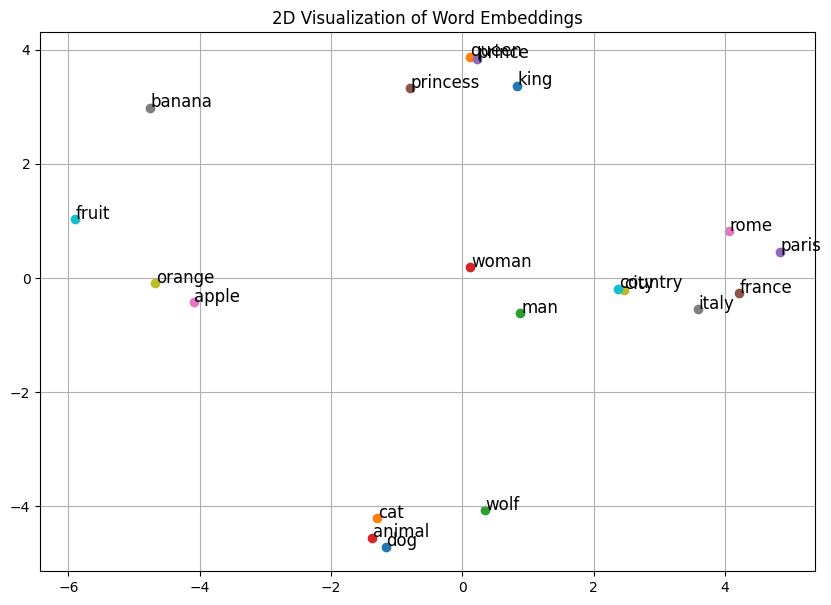

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

words = [
    "king", "queen", "man", "woman", "prince", "princess",
    "apple", "banana", "orange", "fruit",
    "dog", "cat", "wolf", "animal",
    "paris", "france", "rome", "italy", "city", "country"
]


embeddings = model.encode(words)

reduced = PCA(n_components=2).fit_transform(embeddings)
plt.figure(figsize=(10, 7))
for i, word in enumerate(words):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=12)

plt.title("2D Visualization of Word Embeddings")
plt.grid(True)
plt.show()


## Search Algorithms
In the slides we saw a naive implementation of a search algorithm using an inverted index. What if we instead used sentence transformers and search based on cosine similarity?

For this task, we implement the search algorithm by finding the document that has the highest similarity to our query.

In [ ]:
class SearchAlgorithm:

    def __init__(self, model_name="paraphrase-MiniLM-L6-v2", model=None) -> None:
        if model:
            self.model = model
        else:
            self.model = SentenceTransformer(model_name)
        self.stop_words = set(stopwords.words("english"))
        self.lemmatizer = WordNetLemmatizer()
        self.documents = []
        self.document_vectors = []
        self.query_vector = None

    def load_documents(self, documents: list[str]) -> None:
        """
        TODO:
        1.  Load in self.documents with the passed in documents
        2.  Convert each document into a vector with the model
            and store the vectors in self.document_vectors.
        3.  Utilize NLP techniques to preprocess the documents.
        """
        self.documents = documents
        self.document_vectors = [self.model.encode(preprocess_text(doc)) for doc in documents]


    def search(self, query: str, N: int = 3) -> list[str]:
        """
        TODO:
        Write an algorithm to return the N most similar sentences.
        1.  Convert the query into a vector
        2.  Calculate the cosine similariy of the query with sentences
        3.  Order the sentences by similarity and return the top N (hint: np.argsort())
        """
        self.query_vector = self.model.encode(preprocess_text(query))
        scores = cosine_similarity(self.query_vector.reshape(1, -1), np.array(self.document_vectors))
        results = sorted(zip(self.documents, scores[0]), key=lambda x: x[1], reverse=True)
        return [doc for doc, _ in results[:N]]

In [ ]:
# Example of documents related to machine learning
# Already parsed and cleaned/unique

ml_documents = [
    "Artificial intelligence is transforming industries with its ability to mimic human decision-making.",
    "Machine learning enables computers to learn from data and improve over time without being explicitly programmed.",
    "Natural language processing (NLP) allows computers to understand, interpret, and respond to human language in meaningful ways.",
    "Deep learning, a subset of machine learning, utilizes neural networks with multiple layers to extract high-level features from data.",
    "Transformers, a type of deep learning model, have revolutionized natural language processing tasks with their attention mechanism.",
    "Self-supervised learning allows models to learn from raw data without requiring labeled examples.",
    "In reinforcement learning, agents learn by interacting with their environment and receiving rewards or penalties.",
    "Supervised learning requires labeled datasets to train models, while unsupervised learning identifies patterns in data without labels.",
    "Neural networks consist of layers of interconnected nodes that process information similarly to the human brain.",
    "Transfer learning leverages knowledge from one domain to improve performance in another domain.",
    "Text search algorithms help retrieve relevant information from vast datasets using techniques like keyword matching and semantic search.",
    "Inverted indices are commonly used in search engines to quickly find documents containing specific keywords.",
    "Embeddings are vector representations of words, phrases, or documents that capture their semantic meaning.",
    "Cosine similarity is a metric used to measure the similarity between two vectors by calculating the cosine of the angle between them.",
    "Document retrieval systems are designed to search, index, and retrieve documents relevant to user queries.",
    "The bag-of-words model represents text data as a collection of words without considering the order of the words.",
    "TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document relative to a corpus.",
    "Clustering algorithms like K-Means group similar data points together based on features or distance metrics.",
    "Dimensionality reduction techniques like PCA (Principal Component Analysis) reduce the number of features while preserving important information.",
    "Data augmentation techniques like rotation, flipping, and scaling are used in image processing to improve model generalization.",
    "Regularization methods like L2 regularization help prevent overfitting in machine learning models by adding a penalty for large weights.",
    "Gradient descent is an optimization algorithm used to minimize the loss function in machine learning models.",
    "Random forests are ensemble learning methods that combine the outputs of multiple decision trees to make predictions.",
    "Support Vector Machines (SVM) classify data by finding the hyperplane that best separates different classes.",
    "Bayesian networks represent probabilistic relationships among variables and can be used for reasoning under uncertainty.",
    "Markov Chains model systems where the probability of transitioning from one state to another depends only on the current state.",
    "I am a random sentence about biology. I don't have anything to do with the query"
]


query = "What is machine learning?"

In [ ]:
# Number of lines to combine
N = 3

# Example of documents copy and pasted from a machine learning paper
# Documents are partially parsed/cleaned, but are overall less organized
with open('cleaned-tcn-description.txt', 'r') as f:
    documents = f.readlines()
temp = []
for doc in documents:
    if len(doc) <= 5:
        continue
    for sentence in doc.split('.'):
        if len(sentence) <= 5:
            continue
        temp.append(sentence)
documents = temp
new_documents = []
temp = []
for doc in documents:
    if len(temp) == N:
        new_documents.append(' '.join(temp))
        temp = []
    temp.append(doc)
tcn_documents = new_documents
tcn_original_documents = documents.copy()

print("Length of TCN Documents:", len(tcn_documents))
print("Sample line:", tcn_documents[5])

Length of TCN Documents: 58
Sample line: Overview
 A TCN, short for Temporal Convolutional Network, consists of dilated, causal 1D convolutional layers with the same input and output lengths  The following sections go into detail about what these terms actually mean


In [ ]:
## TODO Instantiate class and run search algorithm on a query
search = SearchAlgorithm()
search.load_documents(ml_documents)
search.search("Term document")

['TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document relative to a corpus.',
 'Embeddings are vector representations of words, phrases, or documents that capture their semantic meaning.',
 'Document retrieval systems are designed to search, index, and retrieve documents relevant to user queries.']